In [1]:
from reservoir_rls import *
from lorenz63 import *
from sklearn import preprocessing
from scipy.stats import sem
import cma
from scipy.stats import kstest, norm, shapiro
from multiprocessing import Pool
from min_func import *
from tqdm import tqdm


from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [2]:
step = 0.05
start_time = 125
sync_length = 200
num_tests = 500
train_length = 800
pred_length = 400
base_data_length = int(start_time/step)
data_length = int(base_data_length * step/(0.01))+pred_length
r_t = lambda x: r_t_cosine(x)
dxdt = lambda x,t,r_t: dxdt_lorenz(x,t,r_t)

num_tests = 100
with tqdm(total = num_tests) as pbar:
    for seed in range(num_tests):
        data = getLorenzData(data_length, r_t, dxdt, sample_tau = step, seed = seed)
        if seed == 0:
            optim_data = data[-sync_length - train_length - pred_length:]
        else:
            optim_data = np.vstack((optim_data, data[-sync_length - train_length - pred_length:]))
        pbar.update(1)
print(optim_data.shape)

# scaler = preprocessing.StandardScaler().fit(data)
# scaled_data = scaler.transform(data)
scaled_data = np.copy(optim_data)
scaled_data = np.ascontiguousarray(scaled_data)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.92it/s]

(140000, 3)


In [ ]:
res1 = reservoir(3,210,forget = 0.985, input_weight = 0.017, LM_regularization = 1e-11, \
     t_regularization = 0, delta = 1e6, t_weighted = False, RLS_reg_type = 'LM')
valid_times_norm = cross_validation_performance_separated(scaled_data,res1,num_tests, sync_length, \
               train_length, pred_length, train_method = 'RLS', progress = True)
print(np.median(valid_times_norm))

In [3]:
num_nodes = 210
res_seed = 1
base_res = reservoir(3,num_nodes,input_weight = 1, spectral_radius = 1, seed = res_seed)
mask = ['LM_regularization', 'forget']
x0 = np.array([ 7.9961749362264705, 1.3765879833908092])
min_func = lambda x: vt_min_function_rls(scaled_data, x, mask, base_res.Win, base_res.A, \
     num_tests = num_tests,  num_nodes = num_nodes, pred_length = pred_length, train_length = train_length)
sigma = 4.72e-2

In [4]:
print(cma.CMAOptions())

{'AdaptSigma': 'True  # or False or any CMAAdaptSigmaBase class e.g. CMAAdaptSigmaTPA, CMAAdaptSigmaCSA', 'CMA_active': 'True  # negative update, conducted after the original update', 'CMA_cmean': '1  # learning rate for the mean value', 'CMA_const_trace': 'False  # normalize trace, 1, True, "arithm", "geom", "aeig", "geig" are valid', 'CMA_diagonal': '0*100*N/popsize**0.5  # nb of iterations with diagonal covariance matrix, True for always', 'CMA_eigenmethod': 'np.linalg.eigh  # or cma.utilities.math.eig or pygsl.eigen.eigenvectors', 'CMA_elitist': 'False  #v or "initial" or True, elitism likely impairs global search performance', 'CMA_injections_threshold_keep_len': '1  #v keep length if Mahalanobis length is below the given relative threshold', 'CMA_mirrors': 'popsize < 6  # values <0.5 are interpreted as fraction, values >1 as numbers (rounded), otherwise about 0.16 is used', 'CMA_mirrormethod': '2  # 0=unconditional, 1=selective, 2=selective with delay', 'CMA_mu': 'None  # parents

In [5]:
opts = cma.CMAOptions()
opts.set('popsize',6*x0.size)
opts.set('bounds', [0,10])
opts.set('seed', 5)
opts.set('verb_append', 1)
opts.set('verb_filenameprefix','cmaes_rls_const_weight_starttime%d_res%d\\' % (start_time,res_seed))
results = cma.fmin(min_func, x0, sigma, options = opts)

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 2 (seed=5, Tue Dec  1 10:28:03 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     13 -4.250000000000000e+01 1.0e+00 3.36e-02  3e-02  3e-02 6:30.4
    2     25 -4.250000000000000e+01 1.4e+00 2.63e-02  2e-02  2e-02 12:53.5
    3     37 -4.200000000000000e+01 1.3e+00 2.22e-02  1e-02  2e-02 19:23.2
    4     49 -4.350000000000000e+01 1.5e+00 1.89e-02  1e-02  1e-02 26:03.4
    5     61 -4.250000000000000e+01 1.7e+00 1.32e-02  7e-03  8e-03 32:43.8
    6     73 -4.350000000000000e+01 2.1e+00 1.07e-02  6e-03  7e-03 39:09.4
    7     85 -4.400000000000000e+01 2.2e+00 9.05e-03  4e-03  6e-03 45:41.2
    8     97 -4.300000000000000e+01 3.1e+00 1.26e-02  8e-03  1e-02 52:09.9
    9    109 -4.250000000000000e+01 5.4e+00 1.49e-02  1e-02  1e-02 58:36.1
   10    121 -4.300000000000000e+01 6.0e+00 1.68e-02  1e-02  1e-02 65:05.4
   11    133 -4.300000000000000e+01 4.7e+00 1.60e-02  9e-03  1e-02 71:33.9
   12    145 -4.35

  107   1285 -4.350000000000000e+01 1.3e+02 1.57e-02  7e-04  9e-04 700:49.7
  108   1297 -4.300000000000000e+01 1.5e+02 1.72e-02  8e-04  1e-03 707:16.9
  109   1309 -4.300000000000000e+01 1.8e+02 1.56e-02  7e-04  9e-04 713:44.7
  110   1321 -4.400000000000000e+01 1.7e+02 1.22e-02  5e-04  6e-04 720:11.6
  111   1333 -4.350000000000000e+01 1.7e+02 1.32e-02  4e-04  6e-04 726:39.4
  112   1345 -4.400000000000000e+01 1.3e+02 1.58e-02  5e-04  7e-04 733:06.6
  113   1357 -4.200000000000000e+01 1.0e+02 1.52e-02  5e-04  6e-04 739:39.2
  114   1369 -4.400000000000000e+01 1.2e+02 2.20e-02  6e-04  8e-04 746:08.2
  115   1381 -4.300000000000000e+01 7.6e+01 2.07e-02  5e-04  6e-04 752:35.8
  116   1393 -4.250000000000000e+01 5.5e+01 2.21e-02  5e-04  6e-04 759:03.9
  117   1405 -4.250000000000000e+01 4.8e+01 2.95e-02  5e-04  7e-04 765:33.1
  118   1417 -4.300000000000000e+01 3.3e+01 2.70e-02  4e-04  5e-04 772:02.0
  119   1429 -4.250000000000000e+01 2.1e+01 1.90e-02  2e-04  3e-04 778:39.2
  120   1441

KeyboardInterrupt: 

In [ ]:
input_weight = 5.066848935533839
regs = np.linspace(2,8,25)
forgets = np.linspace(0,5,25)
func_vals = np.zeros((regs.size, forgets.size))

with tqdm(total = regs.size * forgets.size) as pbar:
    for i in range(regs.size):
        for j in range(forgets.size):
            func_vals[i,j] = min_func(np.array([input_weight, regs[i], forgets[j]]))
            np.savetxt('rls_func_vals_weight%f.csv'%input_weight, func_vals, delimiter = ',')
            pbar.update(1)

In [ ]:
plt.pcolor(regs, forgets, -func_vals.T)
plt.colorbar()
plt.show()

In [6]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
def confidence_ellipse(mean_x, mean_y, cov, ax, n_std=1.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    # mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    # mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    print(ellipse)
    return ax.add_patch(ellipse)

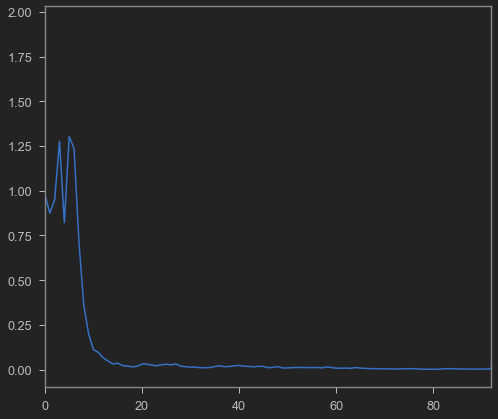

MovieWriter ffmpeg unavailable; using Pillow instead.
c:\users\alexander\anaconda3\envs\reservoir-rls\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
c:\users\alexander\anaconda3\envs\reservoir-rls\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Ellipse(xy=(0, 0), width=1.8815014349741315, height=2.1118599267447364, angle=0)
Ellipse(xy=(0, 0), width=2.0887581227940064, height=1.9071154932153584, angle=0)
Ellipse(xy=(0, 0), width=1.6349277571050738, height=2.3080318951538286, angle=0)
Ellipse(xy=(0, 0), width=1.279814594283455, height=2.5223153260960607, angle=0)
Ellipse(xy=(0, 0), width=1.4789455314143807, height=2.4109583395632193, angle=0)
Ellipse(xy=(0, 0), width=1.2436700128190217, height=2.540331651421667, angle=0)
Ellipse(xy=(0, 0), width=1.041221993652985, height=2.629801657907551, angle=0)
Ellipse(xy=(0, 0), width=1.1866893111698678, height=2.5674439582501476, angle=0)
Ellipse(xy=(0, 0), width=1.4654272154314762, height=2.4191988500891672, angle=0)
Ellipse(xy=(0, 0), width=1.7916754944228708, height=2.188583770999996, angle=0)
Ellipse(xy=(0, 0), width=1.6651676623098552, height=2.2863107086302885, angle=0)
Ellipse(xy=(0, 0), width=1.6715640066847284, height=2.281638396318772, angle=0)
Ellipse(xy=(0, 0), width=1.7342635

c:\users\alexander\anaconda3\envs\reservoir-rls\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
MovieWriter ffmpeg unavailable; using Pillow instead.


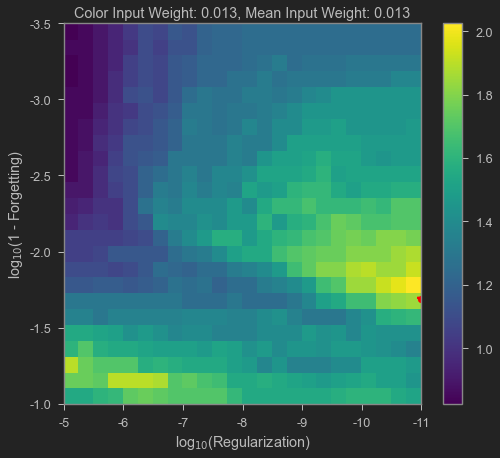

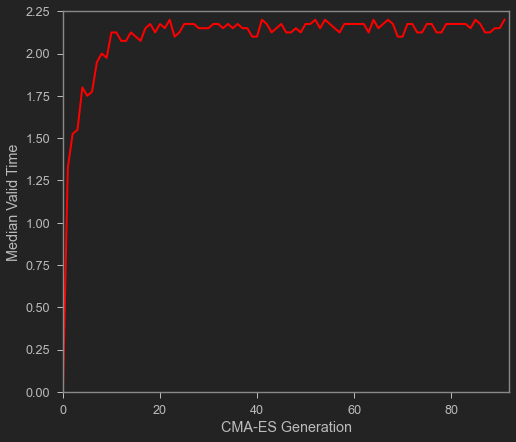

In [15]:
from matplotlib.animation import FuncAnimation
import pandas as pd
step = 0.05
test_weight = 5.066848935533839

covmats = np.loadtxt('cmaes_rls_const_weight_starttime125_res1/covmats.txt', delimiter = ',')
mean_data = np.loadtxt('cmaes_rls_const_weight_starttime125_res1/phenomean.txt', delimiter = ',')[2:]
num_frames = 92
func_vals = np.loadtxt('rls_func_vals_weight%f.csv'%test_weight, delimiter = ',')*step
mean_func = pd.read_csv('cmaes_rls_const_weight_starttime125_res1/fit.dat', sep = ' ', header = None, skiprows = [0]).to_numpy()[:,5]*step
plt.plot(np.max(np.abs(covmats), axis = 1))
plt.xlim(0,num_frames)
plt.show()

weights = np.linspace(2,8,25)
regs = np.linspace(0,5,25)
W, R = np.meshgrid(weights, regs)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

def init_base(ax,W,R,func_vals):
    ax.clear()
    plt.pcolor(W, R, -func_vals.T)
    plt.colorbar()
    ax.set_xlim(2,8)
    ax.set_ylim(0,5)
    xticks = np.linspace(2,8,7)
    yticks = np.linspace(0,5,6)
    xlabels = ['%.0f'%i for i in -xticks-3.0]
    ylabels = ['%.1f'%i for i in -0.5*yticks - 1.0]
    plt.xticks(xticks, xlabels)
    plt.yticks(yticks, ylabels)
    plt.xlabel('log$_{10}$(Regularization)')
    plt.ylabel('log$_{10}$(1 - Forgetting)')

def animate(i,ax,mean_data,covmats,W, R, func_vals, test_weight):
    ax.clear()
    plt.pcolor(W, R, -func_vals.T)
    confidence_ellipse(mean_data[i,0],mean_data[i,1],covmats[i,:].reshape(2,2),ax,edgecolor = 'red', linewidth = 2)
    ax.scatter(mean_data[i,0],mean_data[i,1],c = 'red')
    ax.set_xlim(2,8)
    ax.set_ylim(0,5)
    xticks = np.linspace(2,8,7)
    yticks = np.linspace(0,5,6)
    xlabels = ['%.0f'%i for i in -xticks-3.0]
    ylabels = ['%.1f'%i for i in -0.5*yticks - 1.0]
    plt.xticks(xticks, xlabels)
    plt.yticks(yticks, ylabels)
    plt.xlabel('log$_{10}$(Regularization)')
    plt.ylabel('log$_{10}$(1 - Forgetting)')
    plt.title('Color Input Weight: %.3f, Mean Input Weight: %.3f' % ((test_weight-5)*0.2, (test_weight-5)*0.2))
    
update = lambda i: animate(i,ax,mean_data,covmats,W,R,func_vals,test_weight)
init = lambda : init_base(ax,W,R,func_vals)

ani = FuncAnimation(fig, update, frames = num_frames, init_func = init, blit = False)

ani.save('test_rls_cweight.gif')
fig.show()

fig2 = plt.figure()

ax2 = fig2.add_subplot(1,1,1)
line, = ax2.plot([],[],lw = 2, color = 'red')

def init2(ax2, line, num_frames):
    ax2.set_xlim(0,num_frames)
    ax2.set_ylim(0,2.25)
    ax2.set_xlabel('CMA-ES Generation')
    ax2.set_ylabel('Median Valid Time')
    ax2.grid()
    line.set_data([],[])
    return line,

def animate2(i, line, mean_func):
    line.set_data(np.arange(i+1),np.append(np.array([0]),-mean_func[:i]))
    return line,
    

init_fun = lambda : init2(ax2, line, num_frames)    
update2 = lambda i: animate2(i,line, mean_func)

ani2 = FuncAnimation(fig2, update2, frames = num_frames, init_func = init_fun, blit = True)

ani2.save('test2_rls_cweight.gif')



In [ ]:
res2 = reservoir(3,210,forget = 1, input_weight = 0.25*0.05735187596920699, regularization = 10**(-9.310114193664688), seed = 3)
num_tests = 5000
pred_length = 500
train_length = 400
sync_length = 200
valid_times_norm = cross_validation_performance_resync(scaled_data,res2,num_tests,sync_length, \
   train_length, pred_length,train_method = 'Normal', progress = True)
print(np.median(valid_times_norm))

In [ ]:
res1 = reservoir(3,200,forget = 0.995, input_weight = 0.01, LM_regularization = 1e-10, delta = 1e6)
res2 = reservoir(3,200,forget = 1, input_weight = 0.01, regularization = 1e-7)

In [ ]:
data_length = 100000
step = 0.05
r_t = lambda x: r_t_const(x)
dxdt = lambda x,t,r_t: dxdt_lorenz(x,t,r_t)
data = getLorenzData(data_length, r_t, dxdt, sample_tau = step)

sync_length = 200
num_tests = 500
train_length = 800
pred_length = 500

# scaler = preprocessing.StandardScaler().fit(data)
# scaled_data = scaler.transform(data)
scaled_data = np.copy(data)
scaled_data = np.ascontiguousarray(scaled_data)

In [ ]:
valid_times_RLS = cross_validation_performance(scaled_data,res1,num_tests,sync_length, \
   train_length, pred_length,train_method = 'RLS')
print(np.median(valid_times_RLS))
valid_times_norm = cross_validation_performance(scaled_data,res2,num_tests,sync_length, \
   train_length, pred_length,train_method = 'Normal')
print(np.median(valid_times_norm))

In [ ]:
res1 = reservoir(3,300,forget = 0.985, input_weight = 0.01, regularization = 1e-8, \
     t_regularization = 5e-5, delta = 1e6, t_weighted = True)

In [ ]:
# valid_times_norm_array = np.loadtxt('Lorenz63Data/valid_times_norm_tweight_forget%f_reg%e_treg%e.csv' \
#     %(res1.forget, res1.regularization, res1.t_regularization), delimiter = ',')

In [ ]:
step = 0.05
base_data_length = 25000
data_length = int(base_data_length * step/(0.01))
r_t = lambda x: r_t_cosine(x)
dxdt = lambda x,t,r_t: dxdt_lorenz(x,t,r_t)
valid_times_norm_array = np.array([])

sync_length = 1000
num_tests = 300
train_length = 800
pred_length = 200
completed_seeds = valid_times_norm_array.shape[0]

# scaler = preprocessing.StandardScaler().fit(data)
# scaled_data = scaler.transform(data)
from tqdm import tqdm
with tqdm(total = num_tests) as pbar:
    for seed in range(num_tests):
        data = getLorenzData(data_length, r_t, dxdt, sample_tau = step, seed = seed)
        scaled_data = np.ascontiguousarray(data)
        valid_times_norm = cross_validation_performance_versust(scaled_data,res1,sync_length, \
               train_length, pred_length,pred_gap_length = 100, train_method = 'Normal', progress = False)
        if valid_times_norm_array.size == 0:
            valid_times_norm_array = np.copy(valid_times_norm)
        else:
            valid_times_norm_array = np.vstack((valid_times_norm_array,valid_times_norm))
        np.savetxt('Lorenz63Data/valid_times_norm_tweight_forget%f_reg%e_treg%e.csv' %(res1.forget, res1.regularization, res1.t_regularization), \
            valid_times_norm_array, delimiter = ',')
        pbar.update(1)

In [ ]:
np.savetxt('Lorenz63Data/valid_times_norm_tweight_forget%f_reg%e_treg%e.csv' %(res1.forget, res1.regularization, res1.t_regularization), \
    valid_times_norm_array, delimiter = ',')

In [ ]:
plt.plot(np.mean(valid_times_norm_array*0.05,axis = 0))
plt.ylim(0,5)
plt.show()

In [ ]:
res1 = reservoir(3,300,forget = 0.985, input_weight = 0.01, LM_regularization = 1e-10, \
     t_regularization = 0, delta = 1e6, t_weighted = False, RLS_reg_type = 'LM')
step = 0.05
base_data_length = 5000
data_length = int(base_data_length * step/(0.01))
r_t = lambda x: r_t_cosine(x)
dxdt = lambda x,t,r_t: dxdt_lorenz(x,t,r_t)
valid_times_norm_array = np.array([])

sync_length = 500
num_tests = 100
train_length = 2000
pred_length = 400

In [ ]:
data = getLorenzData(data_length, r_t, dxdt, sample_tau = step, seed = 1)
new_data = np.ascontiguousarray(data)

In [ ]:
res1.trainWoutRLS(scaled_data[2800:3800],200)
res1.valid_time(scaled_data[3800:4200],plot = True, error_bound = 3.2)

In [ ]:
valid_times_norm = cross_validation_performance_separated(scaled_data,res1,sync_length, \
               train_length, pred_length, train_method = 'RLS', progress = False)
print(np.median(valid_times_norm))

In [ ]:
# scaler = preprocessing.StandardScaler().fit(data)
# scaled_data = scaler.transform(data)
from tqdm import tqdm
with tqdm(total = num_tests) as pbar:
    for seed in range(num_tests):
        data = getLorenzData(data_length, r_t, dxdt, sample_tau = step, seed = seed)
        scaled_data = np.ascontiguousarray(data)
        valid_times_norm = cross_validation_performance_versust(scaled_data,res1,sync_length, \
               train_length, pred_length,pred_gap_length = 100, train_method = 'RLS', progress = False)
        if valid_times_norm_array.size == 0:
            valid_times_norm_array = np.copy(valid_times_norm)
        else:
            valid_times_norm_array = np.vstack((valid_times_norm_array,valid_times_norm))
        np.savetxt('Lorenz63Data/valid_times_rls_tweight_forget%f_reg%e_treg%e.csv' %(res1.forget, \
            res1.regularization, res1.t_regularization), valid_times_norm_array, delimiter = ',')
        pbar.update(1)

In [ ]:
plt.plot(np.mean(valid_times_norm_array*0.05,axis = 0))
plt.ylim(0,5)
plt.show()

In [ ]:
x = np.array([[1,2],[3,4]])
np.mean(x,axis = 1)